In [1]:
import base64
import requests
import datetime
from urllib.parse import  urlencode
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import plotly as plt
import plotly.offline as pltof
from plotly import tools
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


client_id = '3fe9bcc656e44bf8bc75a4cad77a675b'
client_secret = '433025007e8a4ccb81b33d1d50020319'

 


* **Data Source :** \
  The data use on this project comes from the **Spotify**\
 *website* : https://www.spotify.com/us/ 
 * document that I use : **Spotify API**
 * website: https://developer.spotify.com/documentation/web-api/reference/
* **Querying code source :** This project is based on the youtube tutorial that create by Coding Entrepreneurs:  30 Days of Python - Day 19 - The Spotify API - Python TUTORIAL. This tutorial is awesome, and here is the link below: 
https://www.youtube.com/watch?v=xdq6Gz33khQ&t=4407s

--------
* **Learning processes**:\
For this huge project, I divided it into several steps to finish it. First, I learn how to query the data by watching the youtube tutorial. This is a 1 hour and 25 minutes video but takes me several days to understand that. Then, after I get the search tool, I spend lots of time finding how to extract those data out from the JSON type of result. When I got my data, I begin to think about how should  I make those data into a data frame. Hence, I thought that I can first try to think about how to convert the JSON to CSV, then from CSV to the data frame will much easier. After I search on Google,  I find out that I can use df.to_csv() to make the JSON file into a nice CSV, and then transfer to the data frame at the end. For data visualization, I can only plot a few graphs such as the line graph and the pie chart. Later on, as I search on the Plotly graph, I realize that I can plot more fun graphs, even the 3D graph. Not only does the coding part take me lots of time, but analyze those music features also time-consuming. I have to search for lots of websites to understand why the data show me that trend. Whereas, I still enjoy this huge project, as it helps me to understand lots of new knowledge either in python or music theory.

# **Step 1: Querying The Data From API**

In [2]:
class SpotifyAPI(object) :
  access_token = None
  access_token_expires = datetime.datetime.now()
  access_token_did_expires = True
  client_id  = None
  client_secret = None 
  token_url = 'https://accounts.spotify.com/api/token'

  def __init__(self,client_id,client_secret, *args, **kwargs):
      '''
      This is the initialize function, and pass our client_id, client_secreat
      Use the superclass to initialize.
      '''
      super().__init__(*args, **kwargs)
      self.client_id = client_id
      self.client_secret = client_secret

  def get_client_credentials(self):
      '''
      From the Spotify document, the header parameter, Authorization required the Base 64 encoded string.
      credentrials obly holds the string type value, so first need to use.encode() receive the byte string. 
      Secoded use base64.b64encode() and convert it to base 64 encoded string. This is a more security way to 
      pass the credentials. Now the type of creds_b64 is bytes. 
      '''
      your_id  = self.client_id 
      your_secret = self.client_secret
      if your_secret == None or your_id == None: 
          raise Exception('You must set clent id and client_secret')
      creds = f'{your_id}:{your_secret}'  # pass your id and your code
      creds_b64 = base64.b64encode(creds.encode())
      return creds_b64.decode()

  def get_token_header(self):
      '''
      Just follow by the document, setting the authorization to base 64 encoded string.
      https://developer.spotify.com/documentation/general/guides/authorization-guide/
      '''
      client_creds_b64 = self.get_client_credentials()
      return   {
            'Authorization' : f'Basic {client_creds_b64}' 
      }


  def get_token_data(self):
      '''
      The request body parameter reuired grant_type, and should be set to the 'client_credentials'.
      Those setting just follow by Spotify doc.
      '''
      return {
              'grant_type': 'client_credentials'
      }
  def perform_auth(self):
      '''
      We basically use the POST method to request the authorization. 
      The request is sent to the /api/token endpoint of the Accounts service.
      '''
      your_url = self.token_url
      Data = self.get_token_data()
      header = self.get_token_header()
      require = requests. post(your_url, data = Data, headers = header)  # use the post method
      if require.status_code not in range(200,299):  #make sure the request in correct status code. return boolean value.
         raise Exception("Could not authentic client")
         #return False 
      detail = require.json()  # return a dictionary that contain the access_token, token_type(Bearer), and expires in seconds
      current = datetime.datetime.now()
      access_token = detail['access_token']
      expires_in = detail['expires_in'] #seconds
      expires = current + datetime.timedelta(seconds = expires_in) #This will return the datetime objects that relative to now.
      self.access_token = access_token
      self.access_token_expires = expires 
      self.access_token_did_expires = expires < current # This return the boolean value
      return True

  def get_access_token(self):
      acess_token = self.access_token  
      token_expires = self.access_token_expires  
      current = datetime.datetime.now()
      if token_expires < current:
           self.perform_auth()
           return self.get_access_token()
      elif acess_token == None:
           self.perform_auth()
           return self.get_access_token()
      return acess_token


  def get_resource_header(self):
      '''
      We use get_resource_header function to get the resource header.
      From the Perform() function, detail return back the token_type is Bearer.
      '''
      access_token = self.get_access_token()
      headers = {
          'Authorization': f'Bearer {access_token}'
      }
      return headers


  def get_resource(self, lookup_id, resource_type = 'albums', version = 'v1'):
      '''
      We use this get_resource functin to get the albums information
      '''
      endpoint = f'https://api.spotify.com/{version}/{resource_type}/{lookup_id}'
      headers = self.get_resource_header()
      r = requests.get(endpoint, headers = headers)
      if r.status_code not in range(200,299):
          return {}
      return r.json()



  def get_album(self, _id):  # get album information
      return self.get_resource(_id, resource_type ='albums')

  def get_artist(self, _id):  #get artist detail
      return self.get_resource(_id, resource_type ='artists')

  def get_features(self,_id):  # get track's freature
      return self.get_resource(_id, resource_type ='audio-features')
  
  def get_anylysis(self,_id):  # get the anylysis for single track
      return self.get_resource(_id, resource_type ='audio-analysis')

      
  
  def base_search(self, query_params):  
      '''
       This is just our basic function. For lookup_url, we need to 
       combine them together as the url acturally is 'https://api.spotify.com/v1/search?q=.....'  
      '''
      headers = self.get_resource_header()
      endpoint = 'https://api.spotify.com/v1/search'
      lookup_url = f'{endpoint}?{query_params}'  
                                               
    
      require = requests.get(lookup_url, headers = headers)
     
      if require.status_code not in range(200,299):
          return {}
      return require.json()

  def search(self, query = None, operator = None, operator_query = None, search_type='artist',limit = None):
      '''
      We primiary use this function to search the imformation:
      From the spotify doc, query and type are the requirment parameters.
      Setting the limit here to maximize the number of track. Otherwise, defualt is 20.

      '''
      if query == None :
          raise Exception(" A query is required ")
      if isinstance(query, dict):
          query = ' '.join([f'{k}: {v}' for k,v in query.items()])
      if operator != None and operator_query != None:
          if (operator.lower() == 'or') or (operator.lower() == 'not'):
                operator = operator.upper()
                if isinstance(operator_query,str):
                  query = f'{query}{operator}{operator_query}'
      query_params = urlencode({'q': query,'type' : search_type.lower(),'limit': limit}) # setting the limit to 50 (Maximum)
      #print(query_params)
      return self.base_search(query_params)


In [3]:
spotify = SpotifyAPI(client_id,client_secret)

# **Step2 : Querying the Billboard Top 50 Songs(From 2003 - 2020)**



* *2020*

In [4]:
#Query : From the billboard 2020

Q_2020= spotify.search(query = ('billboard' and "year:2020"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2020['tracks']['items'][k]['name']
  artists = Q_2020['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2020['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  genres = genres[0]
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2020)  Popularity for song
billboard_2020 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2020 = billboard_2020.sort_values(['Popularity'], ascending=[False])
billboard_2020  = billboard_2020.drop_duplicates(subset=['Song'])
billboard_2020['Year'] = 2020
billboard_2020.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
0,Mood (feat. iann dior),24kGoldn,100,cali rap,488877,2020
9,Dynamite,BTS,97,k-pop,24687985,2020
1,WAP (feat. Megan Thee Stallion),Cardi B,97,pop,13117431,2020
4,What You Know Bout Love,Pop Smoke,96,brooklyn drill,2417359,2020
8,Blinding Lights,The Weeknd,96,canadian contemporary r&b,25511824,2020


* *2019*

In [5]:

# Query : From the billboard 2019

Q_2019 = spotify.search(query = ('billboard ' and "year:2019"),  search_type = ('track'),limit = 50)


#List the Major artists: 
k = 0
List = []
while k < 50:
  song = Q_2019['tracks']['items'][k]['name']
  artists = Q_2019['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2019['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  genres = genres[0]
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2019)  Sort by the Popularity 
billboard_2019 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2019= billboard_2019.sort_values(['Popularity'], ascending=[False])
billboard_2019  = billboard_2019.drop_duplicates(subset=['Song'])
billboard_2019['Year'] = 2019
billboard_2019.head()



,Song,Major Artist,Popularity,genres,total_follow,Year
0,Watermelon Sugar,Harry Styles,94,pop,10320396,2019
9,Breaking Me,Topic,92,edm,106443,2019
7,Someone You Loved,Lewis Capaldi,91,pop,5623813,2019
38,Memories,Maroon 5,89,pop,27679424,2019
3,Sofia,Clairo,89,bedroom pop,1764006,2019


* *2018*

In [6]:
# 2018

#query : From the billboard 2019

Q_2018 = spotify.search(query = ('billboard' and "year:2018"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2018['tracks']['items'][k]['name']
  artists = Q_2018['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2018['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  
  if genres == []:
    genres = genres
  else:
    genres = genres[0]

  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2018)  Sort by popularity for song
billboard_2018 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2018= billboard_2018.sort_values(['Popularity'], ascending=[False])
billboard_2018  = billboard_2018.drop_duplicates(subset=['Song'])
billboard_2018['Year'] = 2018
billboard_2018.head() 

,Song,Major Artist,Popularity,genres,total_follow,Year
1,Lucid Dreams,Juice WRLD,88,chicago rap,13223127,2018
4,SICKO MODE,Travis Scott,88,rap,13402606,2018
7,lovely (with Khalid),Billie Eilish,88,electropop,34618439,2018
0,All Girls Are The Same,Juice WRLD,87,chicago rap,13223127,2018
12,rockstar (feat. 21 Savage),Post Malone,86,dfw rap,29134363,2018


* *2017*

In [7]:
# 2017

#query : From the billboard 2019

Q_2017 = spotify.search(query = ('billboard' and "year:2017"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2017['tracks']['items'][k]['name']
  artists = Q_2017['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2017['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  #print(genres)
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2017)  Sort by Popularity for song
billboard_2017 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2017= billboard_2017.sort_values(['Popularity'], ascending=[False])
billboard_2017  = billboard_2017.drop_duplicates(subset=['Song'])
billboard_2017['Year'] = 2017
billboard_2017.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
0,Jocelyn Flores,XXXTENTACION,87,emo rap,22873284,2017
14,Believer,Imagine Dragons,87,modern rock,30687044,2017
18,Perfect,Ed Sheeran,86,pop,71701934,2017
30,Clean White Noise - Loopable with no fade,Erik Eriksson,85,background music,966,2017
31,Thunder,Imagine Dragons,84,modern rock,30687044,2017


* *2016*

In [8]:
# 2016

#query : From the billboard 2019

Q_2016 = spotify.search(query = ('billboard' and "year:2016"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2016['tracks']['items'][k]['name']
  artists = Q_2016['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2016['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']

  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2016)  Sort by Popularity for song
billboard_2016 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2016= billboard_2016.sort_values(['Popularity'], ascending=[False])
billboard_2016  = billboard_2016.drop_duplicates(subset=['Song'])
billboard_2016['Year'] = 2016
billboard_2016.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
0,goosebumps,Travis Scott,89,rap,13402606,2016
1,Train Wreck,James Arthur,87,pop,6832126,2016
3,Say You Won't Let Go,James Arthur,86,pop,6832126,2016
10,Closer,The Chainsmokers,84,dance pop,16923210,2016
2,I Fall Apart,Post Malone,83,dfw rap,29134363,2016


* *2015*

In [22]:
# 2015

#query : From the billboard 2016

Q_2015 = spotify.search(query = ('billboard' and "year:2015"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2015['tracks']['items'][k]['name']
  artists = Q_2015['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2015['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2015)  Sort by Popularity for song
billboard_2015= pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2015 = billboard_2015.sort_values(['Popularity'], ascending=[False])
billboard_2015 = billboard_2015.drop_duplicates(subset=['Song'])
billboard_2015['Year'] = 2015
billboard_2015.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
0,Electric Love,BØRNS,87,electropop,899095,2015
1,Daddy Issues,The Neighbourhood,85,modern alternative rock,4655139,2015
8,Play Date,Melanie Martinez,85,pop,8362070,2015
2,The Less I Know The Better,Tame Impala,85,australian psych,4294447,2015
6,The Hills,The Weeknd,83,canadian contemporary r&b,25511824,2015


* *2014*

In [9]:
# 2014

#query : From the billboard 2014

Q_2014 = spotify.search(query = ('billboard' and "year:2014"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2014['tracks']['items'][k]['name']
  artists = Q_2014['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2014['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']

  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2014)  Sort by Popularity for song
billboard_2014 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2014= billboard_2014.sort_values(['Popularity'], ascending=[False])
billboard_2014 = billboard_2014.drop_duplicates(subset=['Song'])
billboard_2014['Year'] = 2014
billboard_2014.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
20,Thinking out Loud,Ed Sheeran,84,pop,71701934,2014
37,Photograph,Ed Sheeran,84,pop,71701934,2014
0,No Role Modelz,J. Cole,83,conscious hip hop,11957475,2014
7,Stay With Me,Sam Smith,82,pop,14284917,2014
13,I'm Not The Only One,Sam Smith,82,pop,14284917,2014


* *2013*

In [10]:
# 2013

#query : From the billboard 2013

Q_2013 = spotify.search(query = ('billboard' and "year:2013"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2013['tracks']['items'][k]['name']
  artists = Q_2013['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2013['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2013)  Popularity for song
billboard_2013 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2013= billboard_2013.sort_values(['Popularity'], ascending=[False])
billboard_2013 = billboard_2013.drop_duplicates(subset=['Song'])
billboard_2013['Year'] = 2013
billboard_2013.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
0,Sweater Weather,The Neighbourhood,86,modern alternative rock,4655139,2013
1,All of Me,John Legend,86,neo mellow,5282100,2013
5,Do I Wanna Know?,Arctic Monkeys,84,garage rock,9931822,2013
3,All I Want,Kodaline,83,irish pop,2067724,2013
10,Wake Me Up,Avicii,83,big room,18428271,2013


* *2012*

In [11]:
# 2012

#query : From the billboard 2019

Q_2012 = spotify.search(query = ('billboard' and "year:2012"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2012['tracks']['items'][k]['name']
  artists = Q_2012['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2012['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2012)  Popularity for song
billboard_2012 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2012= billboard_2012.sort_values(['Popularity'], ascending=[False])
billboard_2012  = billboard_2012.drop_duplicates(subset=['Song'])
billboard_2012['Year'] = 2012
billboard_2012.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
3,When I Was Your Man,Bruno Mars,83,dance pop,27329673,2012
5,Can't Hold Us - feat. Ray Dalton,Macklemore & Ryan Lewis,83,dance pop,2533393,2012
10,What Makes You Beautiful,One Direction,82,boy band,18400411,2012
15,Locked out of Heaven,Bruno Mars,82,dance pop,27329673,2012
1,Classic,MKTO,81,dance pop,837979,2012


* *2011*


In [12]:
# 2011

#query : From the billboard 2019

Q_2011 = spotify.search(query = ('billboard' and "year:2011"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2011['tracks']['items'][k]['name']
  artists = Q_2011['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2011['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2011)  Popularity for song
billboard_2011 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2011= billboard_2011.sort_values(['Popularity'], ascending=[False])
billboard_2011  = billboard_2011.drop_duplicates(subset=['Song'])
billboard_2011['Year'] = 2011
billboard_2011.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
1,Pumped Up Kicks,Foster The People,84,indie pop,3023693,2011
0,Tongue Tied,Grouplove,82,indie pop,927093,2011
6,A Thousand Years,Christina Perri,81,dance pop,2736779,2011
28,Paradise,Coldplay,80,permanent wave,27675795,2011
26,"Give Me Everything (feat. Ne-Yo, Afrojack & Na...",Pitbull,79,dance pop,7995594,2011


* *2010*


In [13]:
# 2010

#query : From the billboard 2010

Q_2010 = spotify.search(query = ('billboard' and "year:2010"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2010['tracks']['items'][k]['name']
  artists = Q_2010['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2010['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2010)  Popularity for song
billboard_2010 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2010= billboard_2010.sort_values(['Popularity'], ascending=[False])
billboard_2010  = billboard_2010.drop_duplicates(subset=['Song'])
billboard_2010['Year'] = 2010
billboard_2010.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
1,"Hey, Soul Sister",Train,83,dance pop,3467102,2010
5,Love The Way You Lie,Eminem,82,detroit hip hop,39033066,2010
2,Just the Way You Are,Bruno Mars,80,dance pop,27329673,2010
7,TiK ToK,Kesha,80,dance pop,5905885,2010
22,Not Afraid,Eminem,79,detroit hip hop,39033066,2010


* *2009*

In [14]:
# 2009

#query : From the billboard 2009

Q_2009 = spotify.search(query = ('billboard' and "year:2009"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2009['tracks']['items'][k]['name']
  artists = Q_2009['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2009['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2009)  Popularity for song
billboard_2009 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2009= billboard_2009.sort_values(['Popularity'], ascending=[False])
billboard_2009 = billboard_2009.drop_duplicates(subset=['Song'])
billboard_2009['Year'] = 2009
billboard_2009.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
9,Bad Romance,Lady Gaga,80,dance pop,14409111,2009
14,Empire State Of Mind,JAY-Z,80,east coast hip hop,5708734,2009
5,Fireflies,Owl City,79,indietronica,1989988,2009
7,Down,Jay Sean,79,dance pop,1205142,2009
31,21 Guns,Green Day,76,permanent wave,11296900,2009


* *2008*

In [15]:
# 2008

#query : From the billboard 2009

Q_2008 = spotify.search(query = ('billboard' and "year:2008"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2008['tracks']['items'][k]['name']
  artists = Q_2008['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2008['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
 
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2008)  Popularity for song
billboard_2008 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2008= billboard_2008.sort_values(['Popularity'], ascending=[False])
billboard_2008 = billboard_2008.drop_duplicates(subset=['Song'])
billboard_2008['Year'] = 2008
billboard_2008.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
1,I'm Yours,Jason Mraz,82,acoustic pop,5649534,2008
37,Umbrella,Rihanna,81,barbadian pop,39715331,2008
2,Viva La Vida,Coldplay,80,permanent wave,27675795,2008
7,Low (feat. T-Pain),Flo Rida,80,dance pop,7792830,2008
17,Sex on Fire,Kings of Leon,80,modern rock,4449136,2008


* *2007*

In [16]:
# 2007

#query : From the billboard 2007

Q_2007 = spotify.search(query = ('billboard' and "year:2007"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2007['tracks']['items'][k]['name']
  artists = Q_2007['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2007['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2007)  Popularity for song
billboard_2007 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2007= billboard_2007.sort_values(['Popularity'], ascending=[False])
billboard_2007 = billboard_2007.drop_duplicates(subset=['Song'])
billboard_2007['Year'] = 2007
billboard_2007.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
2,Stronger,Kanye West,81,chicago rap,12681639,2007
9,No One,Alicia Keys,80,hip pop,8043761,2007
4,Electric Feel,MGMT,78,alternative dance,1959763,2007
8,Beautiful Girls,Sean Kingston,78,dance pop,1907008,2007
12,Kids,MGMT,78,alternative dance,1959763,2007


* *2006*

In [17]:
# 2006

#query : From the billboard 2006

Q_2006 = spotify.search(query = ('billboard' and "year:2006"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2006['tracks']['items'][k]['name']
  artists = Q_2006['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2006['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2006)  Popularity for song
billboard_2006 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2006= billboard_2006.sort_values(['Popularity'], ascending=[False])
billboard_2006 = billboard_2006.drop_duplicates(subset=['Song'])
billboard_2006['Year'] = 2006
billboard_2006.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
48,Promiscuous,Nelly Furtado,81,canadian latin,2218434,2006
17,Snow (Hey Oh),Red Hot Chili Peppers,79,alternative rock,14614584,2006
2,Teenagers,My Chemical Romance,78,emo,5358336,2006
8,Put Your Records On,Corinne Bailey Rae,78,british soul,567969,2006
1,Chasing Cars,Snow Patrol,78,irish rock,2104667,2006


* *2005*

In [18]:
# 2005

#query : From the billboard 2005

Q_2005 = spotify.search(query = ('billboard' and "year:2005"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2005['tracks']['items'][k]['name']
  artists = Q_2005['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2005['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']

  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2005)  Popularity for song
billboard_2005 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2005 = billboard_2005.sort_values(['Popularity'], ascending=[False])
billboard_2005 = billboard_2005.drop_duplicates(subset=['Song'])
billboard_2005['Year'] = 2005
billboard_2005.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
5,Hips Don't Lie (feat. Wyclef Jean),Shakira,83,colombian pop,19984871,2005
12,Fix You,Coldplay,82,permanent wave,27675795,2005
0,Hey There Delilah,Plain White T's,81,neo mellow,889224,2005
3,How to Save a Life,The Fray,81,modern rock,3090818,2005
4,Feel Good Inc.,Gorillaz,81,alternative hip hop,6102773,2005


* *2004*

In [19]:
# 2004

#query : From the billboard 2006

Q_2004 = spotify.search(query = ('billboard' and "year:2004"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2004['tracks']['items'][k]['name']
  artists = Q_2004['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2004['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']

  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2004)  Popularity for song
billboard_2004 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2004= billboard_2004.sort_values(['Popularity'], ascending=[False])
billboard_2004 = billboard_2004.drop_duplicates(subset=['Song'])
billboard_2004['Year'] = 2004
billboard_2004.head()

,Song,Major Artist,Popularity,genres,total_follow,Year
1,Yeah! (feat. Lil Jon & Ludacris),Usher,82,atl hip hop,8158654,2004
2,My Boo,Usher,80,atl hip hop,8158654,2004
14,Mr. Brightside,The Killers,80,modern rock,5635999,2004
3,American Idiot,Green Day,79,permanent wave,11296900,2004
30,Gasolina,Daddy Yankee,77,latin,20628804,2004


* *2003*

In [20]:
# 2003

#query : From the billboard 2003

Q_2003 = spotify.search(query = ('billboard' and "year:2003"),  search_type = ('track'),limit = 50)

#List the Major artists:
k = 0
List = []
while k < 50:
  song = Q_2003['tracks']['items'][k]['name']
  artists = Q_2003['tracks']['items'][k]['album']['artists'][0]['name'] 
  Q2 = spotify.search(query = ('genre' and artists),  search_type = 'artist',limit = 5)
  Popula = Q_2003['tracks']['items'][k]['popularity']
  genres = Q2['artists']['items'][0]['genres']
  
  if genres == []:
    genres = genres
  else:
    genres = genres[0]
    
  total_follow = Q2['artists']['items'][0]['followers']['total']
  L = (song,artists,Popula,genres,total_follow)
  List.append(L)
  k+=1


# Make song & artist become dataframe   (2003)  Popularity for song
billboard_2003 = pd.DataFrame(List, columns = ['Song', 'Major Artist','Popularity','genres','total_follow'])
billboard_2003= billboard_2003.sort_values(['Popularity'], ascending=[False])
billboard_2003 = billboard_2003.drop_duplicates(subset=['Song'])
billboard_2003['Year'] = 2003
billboard_2003.head(10)

,Song,Major Artist,Popularity,genres,total_follow,Year
1,Numb,Linkin Park,82,alternative metal,17115843,2003
2,Bring Me To Life,Evanescence,80,alternative metal,2831311,2003
5,Toxic,Britney Spears,80,dance pop,7966787,2003
0,Hey Ya! - Radio Mix,OutKast,79,atl hip hop,1482763,2003
14,The Reason,Hoobastank,79,alternative metal,1601319,2003
3,If I Ain't Got You,Alicia Keys,79,hip pop,8043761,2003
23,Seven Nation Army,The White Stripes,79,alternative rock,2264685,2003
10,Crazy In Love (feat. Jay-Z),Beyoncé,76,dance pop,24935421,2003
31,Dile,Don Omar,75,latin,4612501,2003
18,Are You Gonna Be My Girl,Jet,75,alternative rock,431968,2003


#  **2.2: Billboard Top 50 Dataset(From 2020 to 2003)**





In [23]:
frames = [billboard_2020, billboard_2019,billboard_2018,billboard_2017,billboard_2016,billboard_2015,billboard_2014,billboard_2013,billboard_2012,
          billboard_2011,billboard_2010,billboard_2009,billboard_2008,billboard_2007,billboard_2006,billboard_2005,billboard_2004,billboard_2003]
Data = pd.concat(frames, keys=['2020', '2019','2018','2017','2016','2015','2014','2013','2012','2011','2010','2009','2008','2007','2006','2005','2004','2003'])
Data

Song  ...  Year
2020 0                        Mood (feat. iann dior)  ...  2020
     9                                      Dynamite  ...  2020
     1               WAP (feat. Megan Thee Stallion)  ...  2020
     4                       What You Know Bout Love  ...  2020
     8                               Blinding Lights  ...  2020
...                                              ...  ...   ...
2003 36        The Way You Move (feat. Sleepy Brown)  ...  2003
     29                                Red Dirt Road  ...  2003
     37  All Night Long (All Night) - Single Version  ...  2003
     33                                  Slow Motion  ...  2003
     49                        Simple Man - Acoustic  ...  2003

[896 rows x 6 columns]

* **2.3: Save as CSV file**

In [24]:
Data.to_csv('Billboard(2003-2020).csv',index=False)

 * **2.4 Visualize the genres**
 ---
  *What is the most popular genres among the hit song?*

(-0.5, 799.5, 799.5, -0.5)

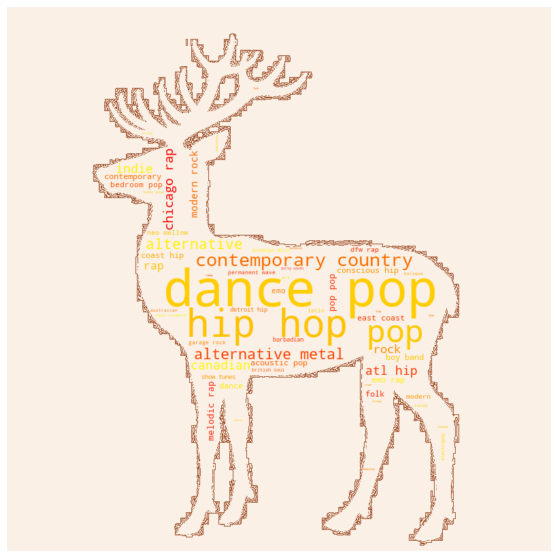

In [25]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt
from PIL import Image



df = pd.read_csv(r'Billboard(2003-2020).csv') 
comment_words = '' 
stopwords = set(STOPWORDS) 
mask = np.array(Image.open("2.png"))


def transform_format(val):
  if val == 7:
    return 255
  else:
    return val

 #Transform mask into a new one 
new_mask = np.ndarray((mask.shape[0],mask.shape[1]),np.int32)

for i in range(len(mask)):
   new_mask[i] = list(map(transform_format,mask[i]))   



for val in df.genres: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "


wordcloud = WordCloud(max_font_size=2000,background_color='linen',
                      colormap='autumn',
                      max_words = 1000,
                      mode='RGB',
                      mask = new_mask,
                      contour_width = 0.2,
                      random_state=1,
                      contour_color = 'sienna',
                      stopwords = STOPWORDS).generate(comment_words) 
  



plt.figure( figsize=(10,10) )
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")



So from the graph above, the data shows that  `dance-pop`, `hip hop`,  `pop` are the most popular genres in billboard. The result seems to reflect popular trends at some level: people love dance-pop.
Back to 2000. The first time that dance-pop became a popular genre was in the 2000s.
According to *The People History*, it points out that : 
> " for a decade filled with much suffering in terms of the September 11th attacks, two wars in the Middle East, and an economic downturn, a lot of the music had to strike a fine balance between upbeat and optimistic while still reflecting the pain that many experienced. Some of the more popular genres of the decade included Dance-Pop, Indie Rock, and Emo."

Perhaps, people  can relieve the pain from those disasters and find hope from the dance-pop. Besides, Dance-pop has strong beats with easy, uncomplicated song structures, so it helps explain why dance-pop still so popular continued 17 years.




# **Step 3 : Play with the music** 

* **3.1 : Why the artists always need to boost popularity?**
---------

In [35]:
#Search: 
import plotly.express as px
def Artist(outcome,time):
  M = spotify.search(query = {'artist': outcome},  search_type = ('track'),limit = 50)
  i = 0
  List = []
  while i < time:
    day = M['tracks']['items'][i]['album']['release_date']
    popularity = M['tracks']['items'][i]['popularity']
    song = M['tracks']['items'][i]['name']
    L = (day,popularity,song)
    List.append(L)
    i += 1


  sort_List = sorted(List, key=lambda x: x[0])
  year_pop = pd.DataFrame(sort_List, columns = ['Year', 'Popularity','Song'])
  year_pop = year_pop.sort_values(['Year'], ascending=[False])

  # Draw the graph:

  fig = px.line_polar(year_pop, r='Popularity', theta='Song', line_close=True)
  fig.update_traces(fill='toself')
  fig.show()
  return year_pop

In [40]:
outcome = input('Who do you want to search?')
time = int(input('How many times your would like to search?(limited 50 times)'))
Artist(outcome,time)

Who do you want to search?Bts
How many times your would like to search?(limited 50 times)20


,Year,Popularity,Song
19,2020-08-28,97,Dynamite
18,2020-07-14,80,Stay Gold
17,2020-07-14,79,Your eyes tell
11,2020-02-21,75,Black Swan
16,2020-02-21,74,Inner Child
15,2020-02-21,76,Friends
14,2020-02-21,75,00:00 (Zero O’Clock)
13,2020-02-21,74,UGH!
12,2020-02-21,76,We are Bulletproof : the Eternal
10,2020-02-21,77,My Time


* **3.2 Simple music search : Let's listen to some music now!**
-----

In [41]:

def find_music(track,Name):
    if (Name == None) or (Name == 'none') or (Name == 'No') or (Name == 'no') or (Name == 'n') or (Name == 'N'): 
      return listen_to_music(track,Name)
    else:
      return this_song(track,Name)



def listen_to_music(track, Name): 
  time = int(input('How many tracks do you want? (choose from 1 to 50 tracks): '))
  G = spotify.search(query = {'track':track},  search_type = 'track',limit = 50) 
  k = 0
  List = []
  while k < time:
    song = G['tracks']['items'][k]['name']
    artist = G['tracks']['items'][k]['album']['artists'][0]['name'] 
    link = G['tracks']['items'][k]['preview_url']
    L = (song, artist,link)
    List.append(L)
    k+=1
  List
  print('Below is your mini-song list and link (30 seconds). Enjoy it: ')
  return List


def this_song(track, Name):
  G = spotify.search(query = {'track':track,'artist' : Name},  search_type = 'track',limit = 1)
  if G['tracks']['items'] == []:
    print("No item found, probabali not put on spotify. Try again: ")
    return search_tool()

  song = G['tracks']['items'][0]['name']
  artist = G['tracks']['items'][0]['album']['artists'][0]['name'] 
  link = G['tracks']['items'][0]['preview_url']
  print('Below is your song list and link (30 seconds): ')
  L = (song, artist,link)
  L
  return L



def search_tool():
  track = input('What song do you want to listen to?\n')
  Name = input('Do you have any specific artists?\n')
  return find_music(track,Name)

In [42]:
search_tool()

What song do you want to listen to?
WAP
Do you have any specific artists?
n
How many tracks do you want? (choose from 1 to 50 tracks): 4
Below is your mini-song list and link (30 seconds). Enjoy it: 


[('WAP (feat. Megan Thee Stallion)',
  'Cardi B',
  'https://p.scdn.co/mp3-preview/1ca9e7769467092ff12a0aee336488ce1b53501c?cid=3fe9bcc656e44bf8bc75a4cad77a675b'),
 ('$ave Dat Money (feat. Fetty Wap & Rich Homie Quan)',
  'Lil Dicky',
  'https://p.scdn.co/mp3-preview/8cc585f73fd793b4c6d0e9394f5031d38fe02bd6?cid=3fe9bcc656e44bf8bc75a4cad77a675b'),
 ('WAP (feat. Megan Thee Stallion)',
  'Cardi B',
  'https://p.scdn.co/mp3-preview/ca1f250631c1dd365d6a70169e83b5df7b874392?cid=3fe9bcc656e44bf8bc75a4cad77a675b'),
 ('Feels Great (feat. Fetty Wap & CVBZ)',
  'Cheat Codes',
  'https://p.scdn.co/mp3-preview/c7072e7308e756e7e8f434f78475b895fbc71dbb?cid=3fe9bcc656e44bf8bc75a4cad77a675b')]

#**Step 4: Analyze the Audio Features**

----
* **4.1 query the features data for billboard Top 50 songs (2003 - 2020)**
------

* *2020*

In [46]:
 
#2020
import json


D = {}
i = 0
while i < 50:
  track_id = Q_2020['tracks']['items'][i]['id']   # Use Q_2020 search the feature data.
  song = Q_2020['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2020.json', 'w') as fp:      
    json.dump(dict, fp,  indent=4)

#Only select the column that we need. some column such as url, id... we do not need in here.
df = pd.read_json (r'Features_2020.json')          
export_csv = df.to_csv (r'New_Features_2020.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2020.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})  
df = DF.set_index('Song')      #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2020 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2020 = DF_2020.astype(float)  #conver the object to numeric type. 
DF_2020['Average_duration(minuts)'] =  (DF_2020['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2020['Average_energy'] = DF_2020['energy'].mean()
DF_2020['Average_speechiness'] = DF_2020['speechiness'].mean()
DF_2020['Average_valence'] = DF_2020['valence'].mean()
DF_2020['Average_danceability']  = DF_2020['danceability'].mean()
DF_2020['Average_tempo'] = DF_2020['tempo'].mean()
DF_2020['Average_liveness'] = DF_2020['liveness'].mean()
DF_2020['Average_acoust'] = DF_2020['acousticness'].mean()
DF_2020['Average_loudness'] = DF_2020['loudness'].mean()
DF_2020['Year'] = 2020
DF_2020.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Mood (feat. iann dior),0.700,0.722,7.0,-3.558,0.0,0.0369,0.2210,0.000000,0.2720,0.756,90.989,140526.0,4.0,3.138315,0.6142,0.1218,0.421852,0.68154,127.66286,0.17877,0.244396,-6.52746,2020
WAP (feat. Megan Thee Stallion),0.935,0.454,1.0,-7.509,1.0,0.3750,0.0194,0.000000,0.0824,0.357,133.073,187541.0,4.0,3.138315,0.6142,0.1218,0.421852,0.68154,127.66286,0.17877,0.244396,-6.52746,2020
For The Night (feat. Lil Baby & DaBaby),0.823,0.586,6.0,-6.606,0.0,0.2000,0.1140,0.000000,0.1930,0.347,125.971,190476.0,4.0,3.138315,0.6142,0.1218,0.421852,0.68154,127.66286,0.17877,0.244396,-6.52746,2020
Laugh Now Cry Later (feat. Lil Durk),0.761,0.518,0.0,-8.871,1.0,0.1340,0.2440,0.000035,0.1070,0.522,133.976,261493.0,4.0,3.138315,0.6142,0.1218,0.421852,0.68154,127.66286,0.17877,0.244396,-6.52746,2020
What You Know Bout Love,0.709,0.548,10.0,-8.493,1.0,0.3530,0.6500,0.000002,0.1330,0.543,83.995,160000.0,4.0,3.138315,0.6142,0.1218,0.421852,0.68154,127.66286,0.17877,0.244396,-6.52746,2020


* *2019*

In [47]:
#2019

D = {}
i = 0
while i < 50:
  track_id = Q_2019['tracks']['items'][i]['id']
  song = Q_2019['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2019.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2019.json')
export_csv = df.to_csv (r'New_Features_2019.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2019.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')      #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2019 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)

#Adding features
DF_2019 = DF_2019.astype(float)  #conver the object to numeric type. 
DF_2019['Average_duration(minuts)'] =  (DF_2019['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2019['Average_energy'] = DF_2019['energy'].mean()
DF_2019['Average_speechiness'] = DF_2019['speechiness'].mean()
DF_2019['Average_valence'] = DF_2019['valence'].mean()
DF_2019['Average_danceability']  = DF_2019['danceability'].mean()
DF_2019['Average_tempo'] = DF_2019['tempo'].mean()
DF_2019['Average_liveness'] = DF_2019['liveness'].mean()
DF_2019['Average_acoust'] = DF_2019['acousticness'].mean()
DF_2019['Average_loudness'] = DF_2019['loudness'].mean()
DF_2019['Year'] = 2019
DF_2019.head()


Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Watermelon Sugar,0.548,0.816,0.0,-4.209,1.0,0.0465,0.122,0.00000,0.3350,0.557,95.390,174000.0,4.0,3.260733,0.56232,0.1251,0.430134,0.66406,116.73172,0.179378,0.305584,-6.971,2019
Circles,0.695,0.762,0.0,-3.497,1.0,0.0395,0.192,0.00244,0.0863,0.553,120.042,215280.0,4.0,3.260733,0.56232,0.1251,0.430134,0.66406,116.73172,0.179378,0.305584,-6.971,2019
Robbery,0.685,0.692,2.0,-5.122,1.0,0.0457,0.328,0.00000,0.1530,0.578,159.966,240051.0,5.0,3.260733,0.56232,0.1251,0.430134,0.66406,116.73172,0.179378,0.305584,-6.971,2019
Sofia,0.744,0.619,0.0,-9.805,1.0,0.0390,0.598,0.00372,0.2310,0.641,112.997,188387.0,4.0,3.260733,0.56232,0.1251,0.430134,0.66406,116.73172,0.179378,0.305584,-6.971,2019
The Box,0.896,0.586,10.0,-6.687,0.0,0.0559,0.104,0.00000,0.7900,0.642,116.971,196653.0,4.0,3.260733,0.56232,0.1251,0.430134,0.66406,116.73172,0.179378,0.305584,-6.971,2019


* *2018*

In [48]:
#2018
D = {}
i = 0
while i < 50:
  track_id = Q_2018['tracks']['items'][i]['id']
  song = Q_2018['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2018.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2018.json')
export_csv = df.to_csv (r'New_Features_2018.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2018.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')      #set the index 
DF= df.transpose()             # swith the column to row to make it clear


#drop data, make it clean
DF_2018 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2018 = DF_2018.astype(float)  #conver the object to numeric type. 
DF_2018['Average_duration(minuts)'] =  (DF_2018['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2018['Average_energy'] = DF_2018['energy'].mean()
DF_2018['Average_speechiness'] = DF_2018['speechiness'].mean()
DF_2018['Average_valence'] = DF_2018['valence'].mean()
DF_2018['Average_danceability']  = DF_2018['danceability'].mean()
DF_2018['Average_tempo'] = DF_2018['tempo'].mean()
DF_2018['Average_liveness'] = DF_2018['liveness'].mean()
DF_2018['Average_acoust'] = DF_2018['acousticness'].mean()
DF_2018['Average_loudness'] = DF_2018['loudness'].mean()
DF_2018['Year'] = 2018
DF_2018.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
All Girls Are The Same,0.671,0.529,0.0,-7.226,1.0,0.3070,0.07690,0.000335,0.0856,0.203,161.989,165820.0,4.0,3.192,0.56636,0.12354,0.43155,0.6885,120.92852,0.161588,0.298617,-7.03296,2018
Lucid Dreams,0.511,0.566,6.0,-7.230,0.0,0.2000,0.34900,0.000000,0.3400,0.218,83.903,239836.0,4.0,3.192,0.56636,0.12354,0.43155,0.6885,120.92852,0.161588,0.298617,-7.03296,2018
SLOW DANCING IN THE DARK,0.515,0.479,3.0,-7.458,1.0,0.0261,0.54400,0.005980,0.1910,0.284,88.964,209274.0,4.0,3.192,0.56636,0.12354,0.43155,0.6885,120.92852,0.161588,0.298617,-7.03296,2018
Whiskey Glasses,0.614,0.680,6.0,-4.580,1.0,0.0289,0.36900,0.000002,0.1150,0.707,149.959,234347.0,4.0,3.192,0.56636,0.12354,0.43155,0.6885,120.92852,0.161588,0.298617,-7.03296,2018
SICKO MODE,0.834,0.730,8.0,-3.714,1.0,0.2220,0.00513,0.000000,0.1240,0.446,155.008,312820.0,4.0,3.192,0.56636,0.12354,0.43155,0.6885,120.92852,0.161588,0.298617,-7.03296,2018


* *2017*

In [49]:
#2017

D = {}
i = 0
while i < 50:
  track_id = Q_2017['tracks']['items'][i]['id']
  song = Q_2017['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2017.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2017.json')
export_csv = df.to_csv (r'New_Features_2017.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2017.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2017 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2017 = DF_2017.astype(float)  #conver the object to numeric type. 
DF_2017['Average_duration(minuts)'] =  (DF_2017['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2017['Average_energy'] = DF_2017['energy'].mean()
DF_2017['Average_speechiness'] = DF_2017['speechiness'].mean()
DF_2017['Average_valence'] = DF_2017['valence'].mean()
DF_2017['Average_danceability']  = DF_2017['danceability'].mean()
DF_2017['Average_tempo'] = DF_2017['tempo'].mean()
DF_2017['Average_liveness'] = DF_2017['liveness'].mean()
DF_2017['Average_acoust'] = DF_2017['acousticness'].mean()
DF_2017['Average_loudness'] = DF_2017['loudness'].mean()
DF_2017['Year'] = 2017
DF_2017.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Jocelyn Flores,0.872,0.391,0.0,-9.144,0.0,0.2420,0.46900,0.000004,0.297,0.437,134.021,119133.0,4.0,3.362976,0.54523,0.095824,0.41854,0.64226,110.95092,0.148278,0.376425,-8.54646,2017
20 Min,0.773,0.750,8.0,-4.009,0.0,0.1170,0.10900,0.000000,0.174,0.783,123.426,220587.0,4.0,3.362976,0.54523,0.095824,0.41854,0.64226,110.95092,0.148278,0.376425,-8.54646,2017
Fuck Love (feat. Trippie Redd),0.797,0.533,0.0,-9.740,0.0,0.0412,0.01720,0.000152,0.103,0.329,131.036,146520.0,4.0,3.362976,0.54523,0.095824,0.41854,0.64226,110.95092,0.148278,0.376425,-8.54646,2017
XO Tour Llif3,0.732,0.750,11.0,-6.366,0.0,0.2310,0.00264,0.000000,0.109,0.401,155.096,182707.0,4.0,3.362976,0.54523,0.095824,0.41854,0.64226,110.95092,0.148278,0.376425,-8.54646,2017
Everybody Dies In Their Nightmares,0.734,0.570,7.0,-7.066,0.0,0.1330,0.84700,0.000021,0.112,0.689,129.953,95467.0,4.0,3.362976,0.54523,0.095824,0.41854,0.64226,110.95092,0.148278,0.376425,-8.54646,2017


* *2016*

In [50]:

#2016

D = {}
i = 0
while i < 50:
  track_id = Q_2016['tracks']['items'][i]['id']
  song = Q_2016['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2016.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2016.json')
export_csv = df.to_csv (r'New_Features_2016.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2016.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')      #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2016 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2016 = DF_2016.astype(float)  #conver the object to numeric type. 
DF_2016['Average_duration(minuts)'] =  (DF_2016['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2016['Average_energy'] = DF_2016['energy'].mean()
DF_2016['Average_speechiness'] = DF_2016['speechiness'].mean()
DF_2016['Average_valence'] = DF_2016['valence'].mean()
DF_2016['Average_danceability']  = DF_2016['danceability'].mean()
DF_2016['Average_tempo'] = DF_2016['tempo'].mean()
DF_2016['Average_liveness'] = DF_2016['liveness'].mean()
DF_2016['Average_acoust'] = DF_2016['acousticness'].mean()
DF_2016['Average_loudness'] = DF_2016['loudness'].mean()
DF_2016['Year'] = 2016
DF_2016.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
goosebumps,0.841,0.728,7.0,-3.370,1.0,0.0484,0.0847,0.000000,0.1490,0.430,130.049,243837.0,4.0,3.651039,0.540032,0.08507,0.440844,0.65116,116.4338,0.15567,0.282007,-7.2045,2016
Train Wreck,0.311,0.485,6.0,-5.726,0.0,0.0365,0.7010,0.000000,0.0726,0.225,77.355,208827.0,4.0,3.651039,0.540032,0.08507,0.440844,0.65116,116.4338,0.15567,0.282007,-7.2045,2016
I Fall Apart,0.556,0.538,8.0,-5.408,0.0,0.0382,0.0689,0.000000,0.1960,0.291,143.950,223347.0,4.0,3.651039,0.540032,0.08507,0.440844,0.65116,116.4338,0.15567,0.282007,-7.2045,2016
Say You Won't Let Go,0.358,0.557,10.0,-7.398,1.0,0.0590,0.6950,0.000000,0.0902,0.494,85.043,211467.0,4.0,3.651039,0.540032,0.08507,0.440844,0.65116,116.4338,0.15567,0.282007,-7.2045,2016
Mr Loverman,0.639,0.526,0.0,-6.697,1.0,0.0256,0.2450,0.000024,0.2500,0.488,130.033,216880.0,3.0,3.651039,0.540032,0.08507,0.440844,0.65116,116.4338,0.15567,0.282007,-7.2045,2016


* *2015*

In [51]:
#2015

D = {}
i = 0
while i < 50:
  track_id = Q_2015['tracks']['items'][i]['id']
  song = Q_2015['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2015.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2015.json')
export_csv = df.to_csv (r'New_Features_2015.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2015.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')      #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2015 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2015 = DF_2015.astype(float)  #conver the object to numeric type. 
DF_2015['Average_duration(minuts)'] =  (DF_2015['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2015['Average_energy'] = DF_2015['energy'].mean()
DF_2015['Average_speechiness'] = DF_2015['speechiness'].mean()
DF_2015['Average_valence'] = DF_2015['valence'].mean()
DF_2015['Average_danceability']  = DF_2015['danceability'].mean()
DF_2015['Average_tempo'] = DF_2015['tempo'].mean()
DF_2015['Average_liveness'] = DF_2015['liveness'].mean()
DF_2015['Average_acoust'] = DF_2015['acousticness'].mean()
DF_2015['Average_loudness'] = DF_2015['loudness'].mean()
DF_2015['Year'] = 2015
DF_2015.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Electric Love,0.611,0.797,6.0,-7.627,0.0,0.0533,0.00543,0.001370,0.2600,0.518,120.041,218107.0,4.0,3.701892,0.56288,0.124006,0.422964,0.628,117.59118,0.167956,0.231212,-7.4206,2015
Daddy Issues,0.588,0.521,10.0,-9.461,1.0,0.0329,0.06780,0.149000,0.1230,0.337,85.012,260173.0,4.0,3.701892,0.56288,0.124006,0.422964,0.628,117.59118,0.167956,0.231212,-7.4206,2015
The Less I Know The Better,0.640,0.740,4.0,-4.083,1.0,0.0284,0.01150,0.006780,0.1670,0.785,116.879,216320.0,4.0,3.701892,0.56288,0.124006,0.422964,0.628,117.59118,0.167956,0.231212,-7.4206,2015
Tennessee Whiskey,0.392,0.370,9.0,-10.888,1.0,0.0298,0.20500,0.009600,0.0821,0.512,48.718,293293.0,4.0,3.701892,0.56288,0.124006,0.422964,0.628,117.59118,0.167956,0.231212,-7.4206,2015
Wait a Minute!,0.764,0.705,3.0,-5.279,0.0,0.0278,0.03710,0.000019,0.0943,0.672,101.003,196520.0,4.0,3.701892,0.56288,0.124006,0.422964,0.628,117.59118,0.167956,0.231212,-7.4206,2015


* *2014*

In [52]:
#2014

D = {}
i = 0
while i < 50:
  track_id = Q_2014['tracks']['items'][i]['id']
  song = Q_2014['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2014.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2014.json')
export_csv = df.to_csv (r'New_Features_2014.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2014.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2014 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2014 = DF_2014.astype(float)  #conver the object to numeric type. 
DF_2014['Average_duration(minuts)'] =  (DF_2014['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2014['Average_energy'] = DF_2014['energy'].mean()
DF_2014['Average_speechiness'] = DF_2014['speechiness'].mean()
DF_2014['Average_valence'] = DF_2014['valence'].mean()
DF_2014['Average_danceability']  = DF_2014['danceability'].mean()
DF_2014['Average_tempo'] = DF_2014['tempo'].mean()
DF_2014['Average_liveness'] = DF_2014['liveness'].mean()
DF_2014['Average_acoust'] = DF_2014['acousticness'].mean()
DF_2014['Average_loudness'] = DF_2014['loudness'].mean()
DF_2014['Year'] = 2014
DF_2014.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
No Role Modelz,0.692,0.521,10.0,-8.465,0.0,0.3300,0.3010,0.0,0.0565,0.463,100.450,292987.0,4.0,3.829704,0.63004,0.082042,0.49174,0.63088,126.61758,0.171814,0.248276,-6.57674,2014
Riptide,0.484,0.731,1.0,-6.694,1.0,0.0379,0.4310,0.0,0.1510,0.510,101.654,204280.0,4.0,3.829704,0.63004,0.082042,0.49174,0.63088,126.61758,0.171814,0.248276,-6.57674,2014
Wet Dreamz,0.517,0.705,6.0,-8.205,0.0,0.3640,0.0751,0.0,0.1280,0.584,175.906,239320.0,4.0,3.829704,0.63004,0.082042,0.49174,0.63088,126.61758,0.171814,0.248276,-6.57674,2014
"Or Nah (feat. The Weeknd, Wiz Khalifa & DJ Mustard) - Remix",0.805,0.330,1.0,-8.712,0.0,0.1000,0.2200,0.0,0.1050,0.211,121.970,242983.0,4.0,3.829704,0.63004,0.082042,0.49174,0.63088,126.61758,0.171814,0.248276,-6.57674,2014
Counting Stars,0.664,0.705,1.0,-4.972,0.0,0.0382,0.0654,0.0,0.1150,0.477,122.017,257840.0,4.0,3.829704,0.63004,0.082042,0.49174,0.63088,126.61758,0.171814,0.248276,-6.57674,2014


* *2013*

In [53]:
#2013


D = {}
i = 0
while i < 50:
  track_id = Q_2013['tracks']['items'][i]['id']
  song = Q_2013['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2013.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2013.json')
export_csv = df.to_csv (r'New_Features_2013.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2013.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2013 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2013 = DF_2013.astype(float)  #conver the object to numeric type. 
DF_2013['Average_duration(minuts)'] =  (DF_2013['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2013['Average_energy'] = DF_2013['energy'].mean()
DF_2013['Average_speechiness'] = DF_2013['speechiness'].mean()
DF_2013['Average_valence'] = DF_2013['valence'].mean()
DF_2013['Average_danceability']  = DF_2013['danceability'].mean()
DF_2013['Average_tempo'] = DF_2013['tempo'].mean()
DF_2013['Average_liveness'] = DF_2013['liveness'].mean()
DF_2013['Average_acoust'] = DF_2013['acousticness'].mean()
DF_2013['Average_loudness'] = DF_2013['loudness'].mean()
DF_2013['Year'] = 2013
DF_2013.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Sweater Weather,0.612,0.807,10.0,-2.810,1.0,0.0336,0.0495,0.0177,0.1010,0.398,124.053,240400.0,4.0,4.057983,0.63996,0.092668,0.448106,0.57636,117.83528,0.180096,0.212029,-6.47062,2013
All of Me,0.422,0.264,8.0,-7.064,1.0,0.0322,0.9220,0.0000,0.1320,0.331,119.930,269560.0,4.0,4.057983,0.63996,0.092668,0.448106,0.57636,117.83528,0.180096,0.212029,-6.47062,2013
Wagon Wheel,0.537,0.660,9.0,-7.174,1.0,0.0296,0.4550,0.0000,0.1350,0.574,148.096,298373.0,4.0,4.057983,0.63996,0.092668,0.448106,0.57636,117.83528,0.180096,0.212029,-6.47062,2013
All I Want,0.209,0.412,0.0,-9.733,1.0,0.0443,0.1720,0.1500,0.0843,0.162,86.260,305747.0,3.0,4.057983,0.63996,0.092668,0.448106,0.57636,117.83528,0.180096,0.212029,-6.47062,2013
Cigarette Daydreams,0.635,0.675,2.0,-3.445,1.0,0.0263,0.0801,0.0000,0.0831,0.273,113.946,208760.0,4.0,4.057983,0.63996,0.092668,0.448106,0.57636,117.83528,0.180096,0.212029,-6.47062,2013


* *2012*

In [54]:

#2012

D = {}
i = 0
while i < 50:
  track_id = Q_2012['tracks']['items'][i]['id']
  song = Q_2012['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2012.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2012.json')
export_csv = df.to_csv (r'New_Features_2012.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2012.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2012 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2012 = DF_2012.astype(float)  #conver the object to numeric type. 
DF_2012['Average_duration(minuts)'] =  (DF_2012['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2012['Average_energy'] = DF_2012['energy'].mean()
DF_2012['Average_speechiness'] = DF_2012['speechiness'].mean()
DF_2012['Average_valence'] = DF_2012['valence'].mean()
DF_2012['Average_danceability']  = DF_2012['danceability'].mean()
DF_2012['Average_tempo'] = DF_2012['tempo'].mean()
DF_2012['Average_liveness'] = DF_2012['liveness'].mean()
DF_2012['Average_acoust'] = DF_2012['acousticness'].mean()
DF_2012['Average_loudness'] = DF_2012['loudness'].mean()
DF_2012['Year'] = 2012
DF_2012.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Money Trees,0.716,0.531,7.0,-7.355,1.0,0.1220,0.07030,0.00000,0.224,0.344,71.994,386907.0,4.0,3.878405,0.6681,0.08062,0.5128,0.61214,118.97498,0.186344,0.144527,-6.0176,2012
Classic,0.720,0.791,1.0,-4.689,1.0,0.1240,0.03840,0.00000,0.157,0.756,102.071,175427.0,4.0,3.878405,0.6681,0.08062,0.5128,0.61214,118.97498,0.186344,0.144527,-6.0176,2012
Everybody Talks,0.471,0.924,8.0,-3.906,1.0,0.0586,0.00301,0.00000,0.313,0.725,154.961,177280.0,4.0,3.878405,0.6681,0.08062,0.5128,0.61214,118.97498,0.186344,0.144527,-6.0176,2012
When I Was Your Man,0.612,0.280,0.0,-8.648,1.0,0.0434,0.93200,0.00000,0.088,0.387,72.795,213827.0,4.0,3.878405,0.6681,0.08062,0.5128,0.61214,118.97498,0.186344,0.144527,-6.0176,2012
Demons,0.505,0.710,3.0,-3.015,1.0,0.0321,0.19000,0.00025,0.329,0.428,89.938,175200.0,4.0,3.878405,0.6681,0.08062,0.5128,0.61214,118.97498,0.186344,0.144527,-6.0176,2012


* *2011*

In [55]:

#2011

D = {}
i = 0
while i < 50:
  track_id = Q_2011['tracks']['items'][i]['id']
  song = Q_2011['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2011.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2011.json')
export_csv = df.to_csv (r'New_Features_2011.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2011.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2011 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2011 = DF_2011.astype(float)  #conver the object to numeric type. 
DF_2011['Average_duration(minuts)'] =  (DF_2011['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2011['Average_energy'] = DF_2011['energy'].mean()
DF_2011['Average_speechiness'] = DF_2011['speechiness'].mean()
DF_2011['Average_valence'] = DF_2011['valence'].mean()
DF_2011['Average_danceability']  = DF_2011['danceability'].mean()
DF_2011['Average_tempo'] = DF_2011['tempo'].mean()
DF_2011['Average_liveness'] = DF_2011['liveness'].mean()
DF_2011['Average_acoust'] = DF_2011['acousticness'].mean()
DF_2011['Average_loudness'] = DF_2011['loudness'].mean()
DF_2011['Year'] = 2011
DF_2011.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Tongue Tied,0.560,0.936,3.0,-5.835,1.0,0.0439,0.00847,0.000,0.1610,0.371,112.960,218013.0,4.0,3.868658,0.68922,0.09619,0.51628,0.6065,128.02468,0.160034,0.189251,-6.15824,2011
Pumped Up Kicks,0.733,0.710,5.0,-5.849,0.0,0.0292,0.14500,0.115,0.0956,0.965,127.975,239600.0,4.0,3.868658,0.68922,0.09619,0.51628,0.6065,128.02468,0.160034,0.189251,-6.15824,2011
Work Out,0.831,0.427,2.0,-6.903,1.0,0.1060,0.05310,0.000,0.3070,0.216,93.004,235320.0,4.0,3.868658,0.68922,0.09619,0.51628,0.6065,128.02468,0.160034,0.189251,-6.15824,2011
Someone Like You,0.559,0.330,9.0,-8.251,1.0,0.0285,0.89200,0.000,0.0975,0.285,135.109,285040.0,4.0,3.868658,0.68922,0.09619,0.51628,0.6065,128.02468,0.160034,0.189251,-6.15824,2011
Midnight City,0.526,0.712,11.0,-6.525,0.0,0.0356,0.01610,0.000,0.1790,0.320,105.009,241440.0,4.0,3.868658,0.68922,0.09619,0.51628,0.6065,128.02468,0.160034,0.189251,-6.15824,2011


* *2010*

In [56]:
#2010  

D = {}
i = 0
while i < 50:
  track_id = Q_2010['tracks']['items'][i]['id']
  song = Q_2010['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2010.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2010.json')
export_csv = df.to_csv (r'New_Features_2010.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2010.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2010 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2010 = DF_2010.astype(float)  #conver the object to numeric type. 
DF_2010['Average_duration(minuts)'] =  (DF_2010['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2010['Average_energy'] = DF_2010['energy'].mean()
DF_2010['Average_speechiness'] = DF_2010['speechiness'].mean()
DF_2010['Average_valence'] = DF_2010['valence'].mean()
DF_2010['Average_danceability']  = DF_2010['danceability'].mean()
DF_2010['Average_tempo'] = DF_2010['tempo'].mean()
DF_2010['Average_liveness'] = DF_2010['liveness'].mean()
DF_2010['Average_acoust'] = DF_2010['acousticness'].mean()
DF_2010['Average_loudness'] = DF_2010['loudness'].mean()
DF_2010['Year'] = 2010
DF_2010.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
No Hands (feat. Roscoe Dash & Wale),0.760,0.595,1.0,-6.366,1.0,0.0391,0.00544,0.000000,0.2410,0.361,131.497,263773.0,4.0,3.906897,0.71154,0.096478,0.533546,0.62812,118.82132,0.210612,0.174217,-5.35326,2010
"Hey, Soul Sister",0.673,0.886,1.0,-4.440,0.0,0.0431,0.18500,0.000000,0.0826,0.795,97.012,216773.0,4.0,3.906897,0.71154,0.096478,0.533546,0.62812,118.82132,0.210612,0.174217,-5.35326,2010
Just the Way You Are,0.637,0.843,5.0,-5.413,1.0,0.0432,0.01510,0.000000,0.0876,0.434,109.012,220733.0,4.0,3.906897,0.71154,0.096478,0.533546,0.62812,118.82132,0.210612,0.174217,-5.35326,2010
Dirt Road Anthem,0.680,0.741,2.0,-5.055,1.0,0.0357,0.34700,0.000002,0.1170,0.635,127.024,229400.0,4.0,3.906897,0.71154,0.096478,0.533546,0.62812,118.82132,0.210612,0.174217,-5.35326,2010
Talking to the Moon,0.523,0.606,1.0,-4.754,0.0,0.0301,0.51200,0.000000,0.1060,0.065,145.837,217867.0,4.0,3.906897,0.71154,0.096478,0.533546,0.62812,118.82132,0.210612,0.174217,-5.35326,2010


* *2009*


In [57]:
#2009
D = {}
i = 0
while i < 50:
  track_id = Q_2009['tracks']['items'][i]['id']
  song = Q_2009['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2009.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2009.json')
export_csv = df.to_csv (r'New_Features_2009.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2009.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2009 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2009 = DF_2009.astype(float)  #conver the object to numeric type. 
DF_2009['Average_duration(minuts)'] =  (DF_2009['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2009['Average_energy'] = DF_2009['energy'].mean()
DF_2009['Average_speechiness'] = DF_2009['speechiness'].mean()
DF_2009['Average_valence'] = DF_2009['valence'].mean()
DF_2009['Average_danceability']  = DF_2009['danceability'].mean()
DF_2009['Average_tempo'] = DF_2009['tempo'].mean()
DF_2009['Average_liveness'] = DF_2009['liveness'].mean()
DF_2009['Average_acoust'] = DF_2009['acousticness'].mean()
DF_2009['Average_loudness'] = DF_2009['loudness'].mean()
DF_2009['Year'] = 2009
DF_2009.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Party In The U.S.A.,0.652,0.698,10.0,-4.667,0.0,0.0420,0.00112,0.000115,0.0886,0.470,96.021,202067.0,4.0,4.012736,0.72974,0.078348,0.51624,0.58632,129.6267,0.22383,0.149988,-5.52972,2009
When I Look At You,0.459,0.545,6.0,-4.874,1.0,0.0282,0.14200,0.000000,0.1050,0.194,137.941,248587.0,3.0,4.012736,0.72974,0.078348,0.51624,0.58632,129.6267,0.22383,0.149988,-5.52972,2009
I Gotta Feeling,0.743,0.766,0.0,-6.375,1.0,0.0265,0.08730,0.000000,0.5090,0.610,127.960,289133.0,4.0,4.012736,0.72974,0.078348,0.51624,0.58632,129.6267,0.22383,0.149988,-5.52972,2009
Day 'N' Nite (nightmare),0.871,0.440,11.0,-6.250,0.0,0.0761,0.49900,0.000004,0.1140,0.799,137.996,221267.0,4.0,4.012736,0.72974,0.078348,0.51624,0.58632,129.6267,0.22383,0.149988,-5.52972,2009
Ain't No Rest for the Wicked,0.634,0.849,0.0,-7.075,1.0,0.1050,0.04380,0.000000,0.3630,0.919,156.004,175493.0,4.0,4.012736,0.72974,0.078348,0.51624,0.58632,129.6267,0.22383,0.149988,-5.52972,2009


* *2008*

In [58]:
#2008
D = {}
i = 0
while i < 50:
  track_id = Q_2008['tracks']['items'][i]['id']
  song = Q_2008['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2008.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2008.json')
export_csv = df.to_csv (r'New_Features_2008.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2008.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2008 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2008 = DF_2008.astype(float)  #conver the object to numeric type. 
DF_2008['Average_duration(minuts)'] =  (DF_2008['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2008['Average_energy'] = DF_2008['energy'].mean()
DF_2008['Average_speechiness'] = DF_2008['speechiness'].mean()
DF_2008['Average_valence'] = DF_2008['valence'].mean()
DF_2008['Average_danceability']  = DF_2008['danceability'].mean()
DF_2008['Average_tempo'] = DF_2008['tempo'].mean()
DF_2008['Average_liveness'] = DF_2008['liveness'].mean()
DF_2008['Average_acoust'] = DF_2008['acousticness'].mean()
DF_2008['Average_loudness'] = DF_2008['loudness'].mean()
DF_2008['Year'] = 2008
DF_2008.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Chicken Fried,0.566,0.713,6.0,-4.250,1.0,0.0417,0.64500,0.000000,0.114,0.807,169.864,238147.0,4.0,3.895346,0.70618,0.074122,0.547252,0.62836,129.27552,0.161234,0.170235,-5.53362,2008
I'm Yours,0.686,0.457,11.0,-8.322,1.0,0.0468,0.59500,0.000000,0.105,0.718,150.953,242187.0,4.0,3.895346,0.70618,0.074122,0.547252,0.62836,129.27552,0.161234,0.170235,-5.53362,2008
Viva La Vida,0.486,0.617,5.0,-7.115,0.0,0.0287,0.09540,0.000003,0.109,0.417,138.015,242373.0,4.0,3.895346,0.70618,0.074122,0.547252,0.62836,129.27552,0.161234,0.170235,-5.53362,2008
"You're Gonna Go Far, Kid",0.550,0.917,0.0,-3.159,1.0,0.0638,0.00428,0.000000,0.197,0.601,126.115,177827.0,4.0,3.895346,0.70618,0.074122,0.547252,0.62836,129.27552,0.161234,0.170235,-5.53362,2008
Hayloft,0.527,0.922,9.0,-2.666,0.0,0.0728,0.00475,0.000162,0.422,0.490,95.975,181680.0,4.0,3.895346,0.70618,0.074122,0.547252,0.62836,129.27552,0.161234,0.170235,-5.53362,2008


* *2007*

In [59]:
#2007
D = {}
i = 0
while i < 50:
  track_id = Q_2007['tracks']['items'][i]['id']
  song = Q_2007['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2007.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2007.json')
export_csv = df.to_csv (r'New_Features_2007.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2007.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2007 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2007 = DF_2007.astype(float)  #conver the object to numeric type. 
DF_2007['Average_duration(minuts)'] =  (DF_2007['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2007['Average_energy'] = DF_2007['energy'].mean()
DF_2007['Average_speechiness'] = DF_2007['speechiness'].mean()
DF_2007['Average_valence'] = DF_2007['valence'].mean()
DF_2007['Average_danceability']  = DF_2007['danceability'].mean()
DF_2007['Average_tempo'] = DF_2007['tempo'].mean()
DF_2007['Average_liveness'] = DF_2007['liveness'].mean()
DF_2007['Average_acoust'] = DF_2007['acousticness'].mean()
DF_2007['Average_loudness'] = DF_2007['loudness'].mean()
DF_2007['Year'] = 2007
DF_2007.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
505,0.520,0.852,0.0,-5.866,1.0,0.0543,0.00237,0.000058,0.0733,0.234,140.267,253587.0,4.0,3.912309,0.75464,0.095632,0.539388,0.59326,122.43872,0.222372,0.137254,-5.56094,2007
Buy U a Drank (Shawty Snappin'),0.451,0.550,1.0,-8.137,1.0,0.2620,0.01080,0.000000,0.0737,0.594,80.001,227960.0,4.0,3.912309,0.75464,0.095632,0.539388,0.59326,122.43872,0.222372,0.137254,-5.56094,2007
Stronger,0.617,0.717,10.0,-7.858,0.0,0.1530,0.00564,0.000000,0.4080,0.490,103.992,311867.0,4.0,3.912309,0.75464,0.095632,0.539388,0.59326,122.43872,0.222372,0.137254,-5.56094,2007
Misery Business,0.517,0.906,1.0,-3.677,1.0,0.0735,0.00272,0.000009,0.1130,0.731,172.977,211520.0,4.0,3.912309,0.75464,0.095632,0.539388,0.59326,122.43872,0.222372,0.137254,-5.56094,2007
Electric Feel,0.763,0.807,1.0,-3.714,1.0,0.0350,0.07140,0.280000,0.3480,0.559,103.038,229640.0,3.0,3.912309,0.75464,0.095632,0.539388,0.59326,122.43872,0.222372,0.137254,-5.56094,2007


* *2006*

In [60]:
#2006
D = {}
i = 0
while i < 50:
  track_id = Q_2006['tracks']['items'][i]['id']
  song = Q_2006['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2006.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2006.json')
export_csv = df.to_csv (r'New_Features_2006.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2006.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2006 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2006 = DF_2006.astype(float)  #conver the object to numeric type. 
DF_2006['Average_duration(minuts)'] =  (DF_2006['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2006['Average_energy'] = DF_2006['energy'].mean()
DF_2006['Average_speechiness'] = DF_2006['speechiness'].mean()
DF_2006['Average_valence'] = DF_2006['valence'].mean()
DF_2006['Average_danceability']  = DF_2006['danceability'].mean()
DF_2006['Average_tempo'] = DF_2006['tempo'].mean()
DF_2006['Average_liveness'] = DF_2006['liveness'].mean()
DF_2006['Average_acoust'] = DF_2006['acousticness'].mean()
DF_2006['Average_loudness'] = DF_2006['loudness'].mean()
DF_2006['Year'] = 2006
DF_2006.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Promiscuous,0.808,0.970,10.0,-6.098,0.0,0.0506,0.056900,0.000061,0.154,0.868,114.328,242293.0,4.0,3.871805,0.737041,0.070955,0.560857,0.632265,120.075469,0.176382,0.141102,-5.350143,2006
Chasing Cars,0.563,0.592,9.0,-4.571,1.0,0.0276,0.209000,0.000051,0.132,0.136,104.016,267933.0,4.0,3.871805,0.737041,0.070955,0.560857,0.632265,120.075469,0.176382,0.141102,-5.350143,2006
Teenagers,0.463,0.857,4.0,-3.063,1.0,0.0632,0.050600,0.000000,0.184,0.856,111.647,161920.0,4.0,3.871805,0.737041,0.070955,0.560857,0.632265,120.075469,0.176382,0.141102,-5.350143,2006
Welcome to the Black Parade,0.217,0.905,2.0,-4.103,1.0,0.0752,0.000289,0.000110,0.222,0.236,96.950,311107.0,4.0,3.871805,0.737041,0.070955,0.560857,0.632265,120.075469,0.176382,0.141102,-5.350143,2006
This Is Halloween,0.569,0.508,7.0,-12.823,1.0,0.0502,0.768000,0.000000,0.145,0.647,167.624,196560.0,4.0,3.871805,0.737041,0.070955,0.560857,0.632265,120.075469,0.176382,0.141102,-5.350143,2006


* *2005*

In [61]:
#2005
D = {}
i = 0
while i < 50:
  track_id = Q_2005['tracks']['items'][i]['id']
  song = Q_2005['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2005.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2005.json')
export_csv = df.to_csv (r'New_Features_2005.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2005.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2005 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2005 = DF_2005.astype(float)  #conver the object to numeric type. 
DF_2005['Average_duration(minuts)'] =  (DF_2005['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2005['Average_energy'] = DF_2005['energy'].mean()
DF_2005['Average_speechiness'] = DF_2005['speechiness'].mean()
DF_2005['Average_valence'] = DF_2005['valence'].mean()
DF_2005['Average_danceability']  = DF_2005['danceability'].mean()
DF_2005['Average_tempo'] = DF_2005['tempo'].mean()
DF_2005['Average_liveness'] = DF_2005['liveness'].mean()
DF_2005['Average_acoust'] = DF_2005['acousticness'].mean()
DF_2005['Average_loudness'] = DF_2005['loudness'].mean()
DF_2005['Year'] = 2005
DF_2005.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Hey There Delilah,0.656,0.291,2.0,-10.572,1.0,0.0293,0.87200,0.00000,0.114,0.298,103.971,232533.0,4.0,3.830502,0.6932,0.095698,0.533904,0.61942,124.09832,0.213824,0.146172,-5.59968,2005
I Write Sins Not Tragedies,0.569,0.830,9.0,-4.106,0.0,0.1400,0.08070,0.00000,0.114,0.609,170.094,186635.0,4.0,3.830502,0.6932,0.095698,0.533904,0.61942,124.09832,0.213824,0.146172,-5.59968,2005
"Sugar, We're Goin Down",0.494,0.842,7.0,-4.784,1.0,0.0843,0.00579,0.00000,0.122,0.574,162.011,229093.0,4.0,3.830502,0.6932,0.095698,0.533904,0.61942,124.09832,0.213824,0.146172,-5.59968,2005
How to Save a Life,0.640,0.743,10.0,-4.080,1.0,0.0379,0.26900,0.00000,0.101,0.361,122.035,262533.0,4.0,3.830502,0.6932,0.095698,0.533904,0.61942,124.09832,0.213824,0.146172,-5.59968,2005
Feel Good Inc.,0.818,0.705,6.0,-6.679,1.0,0.1770,0.00836,0.00233,0.613,0.772,138.559,222640.0,4.0,3.830502,0.6932,0.095698,0.533904,0.61942,124.09832,0.213824,0.146172,-5.59968,2005


* *2004*

In [62]:
# 2004
D = {}
i = 0
while i < 50:
  track_id = Q_2004['tracks']['items'][i]['id']
  song = Q_2004['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2004.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2004.json')
export_csv = df.to_csv (r'New_Features_2004.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2004.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2004 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2004 = DF_2004.astype(float)  #conver the object to numeric type. 
DF_2004['Average_duration(minuts)'] =  (DF_2004['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2004['Average_energy'] = DF_2004['energy'].mean()
DF_2004['Average_speechiness'] = DF_2004['speechiness'].mean()
DF_2004['Average_valence'] = DF_2004['valence'].mean()
DF_2004['Average_danceability']  = DF_2004['danceability'].mean()
DF_2004['Average_tempo'] = DF_2004['tempo'].mean()
DF_2004['Average_liveness'] = DF_2004['liveness'].mean()
DF_2004['Average_acoust'] = DF_2004['acousticness'].mean()
DF_2004['Average_loudness'] = DF_2004['loudness'].mean()
DF_2004['Year'] = 2004
DF_2004.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Mr. Brightside,0.352,0.911,1.0,-5.230,1.0,0.0747,0.001210,0.000000,0.0995,0.236,148.033,222973.0,4.0,3.908228,0.745375,0.109033,0.548056,0.598292,121.518667,0.203817,0.146765,-5.485042,2004
Yeah! (feat. Lil Jon & Ludacris),0.894,0.791,2.0,-4.699,1.0,0.1120,0.018300,0.000000,0.0388,0.583,105.018,250373.0,4.0,3.908228,0.745375,0.109033,0.548056,0.598292,121.518667,0.203817,0.146765,-5.485042,2004
My Boo,0.662,0.507,5.0,-8.238,1.0,0.1180,0.257000,0.000000,0.0465,0.676,86.412,223440.0,4.0,3.908228,0.745375,0.109033,0.548056,0.598292,121.518667,0.203817,0.146765,-5.485042,2004
American Idiot,0.380,0.988,1.0,-2.042,1.0,0.0639,0.000026,0.000079,0.3680,0.769,186.113,176346.0,4.0,3.908228,0.745375,0.109033,0.548056,0.598292,121.518667,0.203817,0.146765,-5.485042,2004
Since U Been Gone,0.662,0.741,0.0,-5.406,1.0,0.0334,0.001650,0.030300,0.1140,0.404,131.000,188960.0,4.0,3.908228,0.745375,0.109033,0.548056,0.598292,121.518667,0.203817,0.146765,-5.485042,2004


* *2003*

In [63]:
#2003

D = {}
i = 0
while i < 50:
  track_id = Q_2003['tracks']['items'][i]['id']
  song = Q_2003['tracks']['items'][i]['name']  
  features = spotify.get_features(track_id) 
  D[song] = features
  i += 1 

#Write to CSV file    
dict = D
with open('Features_2003.json', 'w') as fp:
    json.dump(dict, fp,  indent=4)


df = pd.read_json (r'Features_2003.json')
export_csv = df.to_csv (r'New_Features_2003.csv',index = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','type','id','uri','track_href','analysis_url','duration_ms','time_signature'], header=True)
data = pd.read_csv('New_Features_2003.csv')
DF = pd.DataFrame(data)
DF

# change the column name:
DF = DF.rename(columns={'Unnamed: 0': 'Song'})
df = DF.set_index('Song')    #set the index 
DF= df.transpose()             # swith the column to row to make it clear
DF.head()

#drop data, make it clean
DF_2003 = DF.drop(['uri', 'track_href','analysis_url','id','type'], axis=1)
#Adding features
DF_2003 = DF_2003.astype(float)  #conver the object to numeric type. 
DF_2003['Average_duration(minuts)'] =  (DF_2003['duration_ms'] / 60000).mean()      #conver from millionsecond to minus, fnd mean duration
DF_2003['Average_energy'] = DF_2003['energy'].mean()
DF_2003['Average_speechiness'] = DF_2003['speechiness'].mean()
DF_2003['Average_valence'] = DF_2003['valence'].mean()
DF_2003['Average_danceability']  = DF_2003['danceability'].mean()
DF_2003['Average_tempo'] = DF_2003['tempo'].mean()
DF_2003['Average_liveness'] = DF_2003['liveness'].mean()
DF_2003['Average_acoust'] = DF_2003['acousticness'].mean()
DF_2003['Average_loudness'] = DF_2003['loudness'].mean()
DF_2003['Year'] = 2003
DF_2003.head()

Song,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,Average_duration(minuts),Average_energy,Average_speechiness,Average_valence,Average_danceability,Average_tempo,Average_liveness,Average_acoust,Average_loudness,Year
Hey Ya! - Radio Mix,0.727,0.974,4.0,-2.261,0.0,0.0664,0.103000,0.000532,0.1740,0.965,79.526,235213.0,4.0,3.922348,0.72498,0.103306,0.577676,0.62102,116.636571,0.147045,0.18675,-5.587612,2003
Numb,0.496,0.863,9.0,-4.153,1.0,0.0381,0.004600,0.000000,0.6390,0.243,110.018,185587.0,4.0,3.922348,0.72498,0.103306,0.577676,0.62102,116.636571,0.147045,0.18675,-5.587612,2003
Bring Me To Life,0.331,0.943,4.0,-3.188,0.0,0.0698,0.007210,0.000002,0.2420,0.296,94.612,235893.0,4.0,3.922348,0.72498,0.103306,0.577676,0.62102,116.636571,0.147045,0.18675,-5.587612,2003
If I Ain't Got You,0.609,0.445,7.0,-9.129,1.0,0.1060,0.603000,0.000007,0.1040,0.166,118.393,228707.0,3.0,3.922348,0.72498,0.103306,0.577676,0.62102,116.636571,0.147045,0.18675,-5.587612,2003
Ocean Avenue,0.486,0.904,6.0,-3.751,0.0,0.0638,0.000034,0.000028,0.0947,0.786,173.734,198267.0,4.0,3.922348,0.72498,0.103306,0.577676,0.62102,116.636571,0.147045,0.18675,-5.587612,2003


# **4.2 : Merge to the overall dataset:**
--------
  * Billboard Top 50 songs features overall dataset (2003 - 2020)
 

In [64]:
frames2 = [DF_2020, DF_2019,DF_2018,DF_2017,DF_2016,DF_2015,DF_2014,DF_2013,DF_2012,
          DF_2011,DF_2010,DF_2009,DF_2008,DF_2007,DF_2006,DF_2005,DF_2004,DF_2003]
Data2 = pd.concat(frames2, keys=['2020', '2019','2018','2017','2016','2015','2014','2013','2012','2011','2010','2009','2008','2007','2006','2005','2004','2003'])
Data2

Song                                          danceability  ...  Year
2020 Mood (feat. iann dior)                          0.700  ...  2020
     WAP (feat. Megan Thee Stallion)                 0.935  ...  2020
     For The Night (feat. Lil Baby & DaBaby)         0.823  ...  2020
     Laugh Now Cry Later (feat. Lil Durk)            0.761  ...  2020
     What You Know Bout Love                         0.709  ...  2020
...                                                    ...  ...   ...
2003 Faint                                           0.554  ...  2003
     Me, Myself and I                                0.750  ...  2003
     Tu Cárcel                                       0.815  ...  2003
     Pa' Que Retozen                                 0.815  ...  2003
     Simple Man - Acoustic                           0.568  ...  2003

[896 rows x 23 columns]

* **4.3 : Save it to CSV file**
------

In [65]:
Data2.to_csv('Features(2003-2020).csv',index=False)

* **4.4 : Check the correlation**
----------
   *Are those features correlate to each other?*

In [66]:
# first check the type of dataframe, and find is object. This type can not find the correlation, so we need to transfer the type to float.
import seaborn as sns; sns.set_theme()
df2=Data2.astype(float)
df2 = df2.drop(columns=['key', 'mode','Year','Average_duration(minuts)','Average_energy','Average_speechiness','Average_valence','Average_danceability','Average_tempo','Average_liveness','Average_acoust','Average_loudness'])


* *Let's use heatmap to check it.*

In [67]:
df2.corr().style.background_gradient(cmap='YlGnBu').set_precision(2) # use correlation select the features.


Song,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
Song,,,,,,,,,,,
danceability,1.00,-0.06,0.10,0.19,-0.07,-0.14,-0.08,0.33,-0.09,-0.12,0.32
energy,-0.06,1.00,0.75,0.02,-0.62,-0.16,0.20,0.46,0.22,0.01,0.25
loudness,0.10,0.75,1.00,-0.02,-0.49,-0.35,0.13,0.35,0.23,0.05,0.41
speechiness,0.19,0.02,-0.02,1.00,-0.07,-0.09,0.05,0.07,0.06,-0.02,0.11
acousticness,-0.07,-0.62,-0.49,-0.07,1.00,0.14,-0.13,-0.20,-0.16,-0.09,-0.18
instrumentalness,-0.14,-0.16,-0.35,-0.09,0.14,1.00,-0.01,-0.12,-0.05,-0.07,-0.26
liveness,-0.08,0.20,0.13,0.05,-0.13,-0.01,1.00,0.02,0.03,0.04,0.03
valence,0.33,0.46,0.35,0.07,-0.20,-0.12,0.02,1.00,0.06,-0.11,0.22
tempo,-0.09,0.22,0.23,0.06,-0.16,-0.05,0.03,0.06,1.00,0.02,0.17


---
According to this headmap, the darker the color, the stronger the relationship. Hence, seems like the loudness has some positive relationship with the energy, as the correlation coefficient is 0.75.

---



# **Step 5: Data Visualization** : *Find the secreat behind those data*

> *What does those data tell us*?
------
* Dataset: Billboard Top 50 songs (2003 -- 2020)

* **5.1: Analyze the average track duration**
---
*How the average length of a song changed over 17 years?*

In [68]:

# Create traces


x = Data2['Year']
y = Data2['Average_duration(minuts)']


fig = go.Figure(data=go.Scatter(x=x, y=y,mode='lines+markers',name='Average duration',line_color="#3f8ba1"))

fig.update(layout_title_text='The Average duration of Billboard Top 50 songs (2003 - 2020) in minutes',
           layout_showlegend=True)

fig.update_xaxes(
        title_text = "Year",
        title_standoff = 25)

fig.update_yaxes(
        title_text = "Average duration (in minutes)",
        title_standoff = 25)



fig.show()


*From the graph above, the line trend indicates that the average duration of track is getting short, typically after 2013. One main factor is streaming-media. Data from RIAA( The Record Industry Association) shows that streaming revenue is 75% of the music industry's revenue. According to the DiGital Music News, Dylan Smith points out that:* 
> “ Spotify is often criticized for having one of the lowest payments per stream, between $0.003 and $0.005 per play.” 

*Within the same amount of time, shorter songs played more times, and it returns musicians a higher share of the revenue.*




*Besides, as technology developed so fast, we are now in the era of information explosion: all kinds of information rapidly increase but are hard to manage. Some applications like tik tok are now shorter in our attention through the fragmentation propagation. At some level, our perception is changing: one minus video is longer than it used to be, as people nowadays more easily concentrate within 10 to 15 seconds.*








* **5.2: Analyze the average energy & tempo**
---
How the average energy and tempo changes among 17 years?

In [69]:
x = Data2['Year']
y = Data2['Average_energy']
fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y,mode='lines+markers',name='Average Energy',line_color = '#ffff08'))

fig.update(layout_title_text='Average energy of Billboard top 50 songs from 2003 to 2020',
           layout_showlegend=True)
fig.update_xaxes(
        title_text = "Year",
        title_standoff = 25)

fig.update_yaxes(
        title_text = "Average energy",
        title_standoff = 25)

fig.show()



# Average_tempo
x1 = Data2['Year']
y1 = Data2['Average_tempo']


# Create traces

fig1 = go.Figure()

fig1.add_trace(go.Scatter(x=x1, y=y1,mode='lines+markers',name='Average tempo',line_color = '#a5c73e'))

fig1.update(layout_title_text='Average tempo of Billboard top 50 songs from 2003 to 2020',
           layout_showlegend=True)

fig1.update_xaxes(
        title_text = "Year",
        title_standoff = 25)

fig1.update_yaxes(
        title_text = "Average tempo",
        title_standoff = 25)


fig1.show()


* *In music theory, high energy tracks sound fast and noisy; lower energy tracks sound slow and peaceful. From the average energy of billboard top 50 songs from 2003 to 2020 above, the average energy of songs showed a downward trend, especially from 2009 to 2016. After 2017, the average energy gradually recovered. The point in 2017 indicates that pop music is getting slower and relatively quiet compared to the past ten years.*

* *Besides, the average tempo can also refect this case. On an average tempo of a billboard top 50 songs from 2003 to 2020, the mean tempo is relatively high between 2003 and 2016. It indicates that the beat of popular music is relatively fast, especially from 2008 to 2009, which is close to 130. In 2017, the average tempo reached the lowest level, indicating pop music is relatively slow in 2017.*

* *Combining those two graphs, the line trend in both average energy and tempo suggests that pop music was relatively faster and noisier before 2016. From 2016 to 2017, pop music began to be relatively slow and quiet. Then, it goes back to a relatively fast and noiser again. Several factors like social anxiety, social pressure may help to explain this situation. According to Pop music is slowing down as people feel more reflective in 'dark times', Phoebe Weston explains that:*

> " Slow-burning ballads could also be a sign the country is feeling more reflective. As the sociopolitical climate got darker, people did not want to hear upbeat bop". 



 

* **5.3: Analyze the average valence**

-------------
Are those song getting people happy or sad?

In [70]:
import plotly.express as px
x = Data2['Year']
y = Data2['Average_valence']

fig = px.scatter(Data2, x=x, y=y ,
	         size='Average_valence', color='Year',
                 hover_name='Average_valence', log_x=True, size_max=30)

fig.update(layout_title_text='Average valences of Billboard top 50 songs from 2003 to 2020',
           layout_showlegend=True)

fig.update_xaxes(
        title_text = "Year",
        title_standoff = 25)



fig.show()

Valence describes the musical positiveness conveyed by a track. high valence sounds more positive (e.g. happy, cheerful, euphoric), while low valence sounds more negative (e.g. sad, depressed, angry). Based on the average valence of billboard top 50 songs, it shows that the average valence is in decline. This suggests that the mood of pop music in recent decades has tended towards depression. This result also proves the analysis in the previous section. What’ more, according to *Is pop music really getting sadder and angrier?*, Lior Shamir points out that:
> “ You see a very consistent, very clear change that lyrics become angrier, more fearful, sadder, and less joyful.”


Recall the analysis in the previous section, both the average energy and the average tempo is racing from 2018 to 2020. It seems like Pop music in recent years is releasing high energy, but instead of happiness or brightness, pop music is releasing nonpositive energy such as anger, sadness, fear.


Therefore, songs are like a mirror of society: what is happening right now can be reflected in the songs. Hence, the negative tone in recent pop music also reflects changes in society, and even though artists do not express the protest songs publicly about political events, they can still influence the overall mood. 



* **5.4 : find the simple relationship between energy and loundess**
---------
How does the energy effect the loudness? 

In [71]:
# compare the energy with loundess 
import plotly.express as px

fig = px.scatter(
    Data2, x='energy', y='loudness', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue'
)


fig.update(layout_title_text='Find the relationship between the energy and loudness',
           layout_showlegend=True)


fig.show()





/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



From the graph above, we find that energy and loudness has linear relashiop, more specifically, the energy and loudness has upward trend. The R^2 is around 0.558801, which is means that around 55.9% of loudness data can be explained by the energy data. No so good, as the higher the R-squared, the better the model fits the data. The graph also shows some outliers.
Nevertheless, this graph still shows that as energy gets larger, the music will getting more noise as the value of loudness also getting larger. 


* **5.5 : Average speechiness & Average danceability**

-------

What is the trend of average speechiness and daceability?

In [72]:

fig = px.scatter_3d(Data2, z ='Average_danceability', x ='Average_speechiness', y ='Year',
                    size = 'Average_speechiness', size_max = 10, color = 'Year', hover_name = 'Year')



fig.update(layout_title_text='Average danceability and speechiness of Billboard top 50 songs from 2003 to 2020',
           layout_showlegend=True)


fig.show()


Based on the graph above, the darker the dot, the higher the value. Therefore, the average spechiness and danceability are increasing in recent years. 

# **Step 6: Make a Hit Song**

------------
*Is there any formular to creat a billborad songs?*

* **6.1: Analyze the time signature**
---------
What is the most common time signature?
   * Let's first check out the number and type of the time signature.

In [73]:
Data2['time_signature'].value_counts()

4.0    837
3.0     40
5.0     11
0.0      4
1.0      4
Name: time_signature, dtype: int64

The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). Therefore, it has 3 type of time sinature, which are 4/4, 3/4, and 5/4, 0(free time: It is used when a piece of music has no discernible beat.), 1/4.

In [74]:
# data visualization by pie chart
import plotly.graph_objects as go
sunflowers_colors = ['#b80606','#f0836a','#c6c6c6','#a6bbc9',
                     '#81b0cc']

labels =['4/4','3/4','5/4','0','1/4']
values = Data2['time_signature'].value_counts()

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3,marker_colors=sunflowers_colors)])
fig.update(layout_title_text='Time_signature distribution',
           layout_showlegend=True )



fig.show()

From this pie chart we can see that majority of the time signature is 4/4，more specifically, 93.4% of the pop music use 4/4 beat, and 4.47% of pop music use 3/4 beat. Why most pop song like to use 4/4 beat? Most common answer is that rhymes based on powers of two can easily be compounded or subdivided. In this case, 4/4 can be seen as 2 bars of two, or half of a bar of eight. 
> **Formular 1: Using 4/4 as your time signiture.**


* **6.2 : Analyze the mode**
-----
Which is more popular, major or minor?

In [75]:

# Major/ Minor
sunflowers_colors = ['#f0e98b','#87dfcb']

labels =['Major','Minor']
values = Data2['mode'].value_counts()

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3,marker_colors=sunflowers_colors)])
fig.update(layout_title_text='The Mode distribution in Billboard top 50 songs (2003 - 2020)',
           layout_showlegend=True)






fig.show()

Based on this pie chart, approximately 66.5% of hit songs prefer the major, and 33.5% of hit songs use the minor.
> **Formula 2 : make your song in major.**

* **6.3 : Anlyze the key**
  * Let's first check the type and number for the Key.
  * For the pith class: 
                   1  = C#(Db), 0 = C , 5 = F, 
                   7 = G , 2 = D, 8 = G#(Ab), 
                   11 = B, 6 = F#(Gb), 10 = A#(Bb),
                   9 = A, 4 = E, 3 = D#(Eb)

In [76]:
Data2['key'].value_counts() #check the type and number for the Key.

1.0     111
0.0     102
5.0      92
7.0      86
2.0      76
8.0      75
6.0      70
11.0     68
4.0      67
9.0      61
10.0     60
3.0      28
Name: key, dtype: int64

In [77]:
# data visualization by pie chart
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows = 1, cols = 2, specs= [[{'type': 'domain'},{'type' : 'domain'}]])


sunflowers_colors = ['#faeb19', '#fff17a', '#fff8be',
                     '#d9c1c7', '#ebbcc8','#fcb6c9','#cfcfcf',
                     '#b6c4ce','#9dbacd','#81b0cc','#9dc9c2','#5cbdb0']

labels =['C#(Db)','C','F','G','D','G#(Ab)','B','F#(Gb)','A#(Bb)','A','E','D#(Eb)']
values = Data2['key'].value_counts()

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3,marker_colors=sunflowers_colors)])
fig.update(layout_title_text='Major key in Billboard top 50 songs (2003 - 2020)',layout_showlegend=True)




fig.show()

From the graph above, we can see that most hit song choose C#/ Db, approximate 12.5%, and around 11.3% hit song choose C, around 10.2% choose F, and still has 9.5% choose G.
> **Formula 3 : choose either C#(Db), C, or F as you key because those are top key that the hit song like it.**


Notification: there has differenct character of music key:
> C major: Innocently Happy. 

> Db major: Grief, Depressive.


> F major: Furious, Quick_Tempered, Passing Regret. 




For making a hit song, the formular are:
**4/4 time_signature** + **Major** + **Key**{C#(Db) or C or F} 

# **Conclusion:**



**1.** Dance-pop and hip-pop are still the mainstream among all genres. Not only do people need it to release the negative emotion, but also the fast rhythms and more spread out.\
**2**. The average duration of a song is getting shorter since the revenue for the artists is relative to streaming-media. The shorter the length of the tracker, the higher the profit that artists can earn for each time.\
**3**. The pop songs used to get slow and peaceful from 2016 to 2017, and later it back to fast and noise in recent years. However, instead of release positive energy, the pop song in recent years releases more negative energy.\
**4**. The secret of making a hit song is:\
4/4 (time signature) + Major + C/ C#/Db/F (key).

Reference:
* CodingEntrepreneurs. (2020, April 26). 30 Days of Python - Day 19 - The Spotify API - Python TUTORIAL. Retrieved November 10, 2020, from https://www.youtube.com/watch?v=xdq6Gz33khQ&t=4407s

* AppleInsider Staff. (2020,May 5). Streaming now accounts for 79% of US music industry revenue, RIAA says. Retrived November 09, 2020, from https://icrowdmarketing.com/streaming-now-accounts-for-79-of-us-music-industry-revenue-riaa-says/ 
* Robson, D. (2019, May 13). Is pop music really getting sadder and angrier? Retrieved November 09, 2020, from https://www.bbc.com/culture/article/20190513-is-pop-music-really-getting-sadder-and-angrier
* Weston, P. (2017, August 21). Pop music is slowing down as people feel more reflective. Retrieved November 09, 2020, from https://www.dailymail.co.uk/sciencetech/article-4809010/Pop-music-slowing-dark-times.html
* Yamashita, S. (2020, August 23). Spotify's Success May Be the Real Day the Music Dies. Retrieved November 09, 2020, from https://whowhatwhy.org/2020/08/22/spotifys-success-may-be-the-real-day-the-music-dies/

